# Startup

In [2]:
from importlib import reload
from datetime import date
from os import path, makedirs

import numpy as np
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.termination import get_termination
from pymoo.optimize import minimize
from pymoo.core.problem import Problem
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

# from cam_class_optimization import CamGeneration
import cam_class_optimization
from cam_class_optimization import CamGeneration

# Define problem parameters. Forces are in Newtons, lengths are in meters.
angle_data = 'data/Knee-angle_Chugo_2006.csv'
user_height = 1.654 # 1.654 is avg. height of subjects 55+ in NHANES 2017-2020
k_elastic = 200
sit_angle_deg = 220
offset_angle_deg = 180
target_force_max = 200
target_force_range = 25
target_percentage_max = 32.5
target_percentage_range = 5
target_sitting_max = 25
target_radius_max = 0.0635
dateStr = date.today().strftime("%Y-%m-%d")

# Designate location of standing and storage cam point clouds
folder_path = 'results/cam_plots/cam_plots_2024-06-13_K=100/'
cam_idx = 63

# Junk code for CamGeneration init
x = np.ones(17)
gear_ratios = x[: 8]
input_angles = x[8 : -1]
scaling = x[-1]

<Figure size 640x480 with 0 Axes>

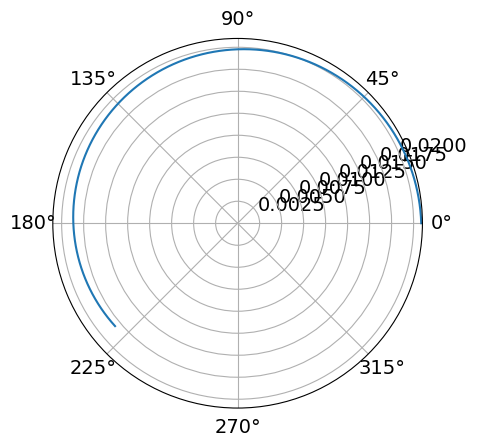

/Users/stephan/cam-mech/cam_class_optimization.py:533: OptimizeWarning: Unknown solver options: verbose
  result = minimize(objective, x0, options={'verbose': 2},
Traceback (most recent call last):
  File "_pydevd_bundle/pydevd_cython.pyx", line 577, in _pydevd_bundle.pydevd_cython.PyDBFrame._handle_exception
  File "_pydevd_bundle/pydevd_cython.pyx", line 312, in _pydevd_bundle.pydevd_cython.PyDBFrame.do_wait_suspend
  File "/opt/miniconda3/envs/pymoo/lib/python3.10/site-packages/debugpy/_vendored/pydevd/pydevd.py", line 2070, in do_wait_suspend
    keep_suspended = self._do_wait_suspend(thread, frame, event, arg, suspend_type, from_this_thread, frames_tracker)
  File "/opt/miniconda3/envs/pymoo/lib/python3.10/site-packages/debugpy/_vendored/pydevd/pydevd.py", line 2106, in _do_wait_suspend
    time.sleep(0.01)
KeyboardInterrupt


TypeError: CamGeneration.generate_sit_cam.<locals>.callback_fun() missing 1 required positional argument: 'x'

In [12]:
reload(cam_class_optimization)
from cam_class_optimization import CamGeneration
Cam = CamGeneration(gear_ratios, input_angles, scaling,
                    sit_angle=np.pi/180*sit_angle_deg,
                    offset_angle=np.pi/180*offset_angle_deg)

Cam.generate_sit_cam(folder_path, cam_idx)

In [ ]:
def generate_cam(x, plot=False, save=False, index=0):
    """ Generates a cam from the given gear ratios, input angles, and scaling.
    """
    gear_ratios = x[: 8]
    input_angles = x[8 : -1]
    scaling = x[-1]

    Cam = CamGeneration(gear_ratios, input_angles, scaling,
                        sit_angle=np.pi/180*sit_angle_deg,
                        offset_angle=np.pi/180*offset_angle_deg)
    pts_inner, pts_outer, radius_max = Cam.calculate_cam_radii(user_height,
                                                               k_elastic,
                                                               plot, index)
    if np.any(np.isnan(pts_inner)) or np.any(np.isinf(pts_inner)):
        return np.inf, np.inf, 0, np.inf
    forces, percentages = Cam.calc_forces_percentages(angle_data,
                                                      k_elastic,
                                                      torque=False,
                                                      plot=plot,
                                                      index=index)
    force_max = max(forces)
    if not np.isnan(force_max):
        perc_force_max = percentages[np.where(forces == force_max)[0][0]]
        perc_sitting_ind = np.where(np.round(percentages, 1) == 0)[0][0]
        force_sitting = forces[perc_sitting_ind]

        if save:
            filepath = 'results/cam_plots/cam_plots_' + dateStr
            if not path.exists(filepath):
                makedirs(filepath) 
            file_inner = filepath + '/inner_' + str(index) + '.txt'
            file_outer = filepath + '/outer_' + str(index) + '.txt'
            np.savetxt(file_inner, np.append(pts_inner * 1000,
                                          np.zeros((pts_inner.shape[0], 1)),
                                          axis=1), delimiter=',')
            np.savetxt(file_outer, np.append(pts_outer * 1000,
                                          np.zeros((pts_outer.shape[0], 1)),
                                          axis=1), delimiter=',')

        return radius_max, perc_force_max, force_max, force_sitting
    else:
        return np.inf, np.inf, 0, np.inf